# YouTube Subtitle Analysis
Here we go and analyze subtitles fetched from YouTube.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [17]:
import matplotlib.pylab as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [18]:
import sqlite3
import pandas as pd
import isodate

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)

data['publishedAt'] = pd.to_datetime(data['publishedAt']).dt.tz_convert('Europe/Berlin')
data['updated'] = pd.to_datetime(data['updated']).dt.tz_convert('Europe/Berlin')

data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')

data['tags'] = data['tags'].apply(lambda t: t.split("'")[1::2])
data['duration'] = data['duration'].apply(lambda t: isodate.parse_duration(t).total_seconds())

no_subs_ids = data['subtitle'].apply(lambda x: len(x) <= 10)
# data.loc[no_subs_ids, 'subtitle'] = data.loc[no_subs_ids, 'description']

data.set_index('videoId', inplace=True)

## Variables
### Dates and periods

In [19]:
from datetime import datetime as time, timedelta
import pytz

cest = pytz.timezone("Europe/Berlin")

bt_election = time.fromisoformat('2017-09-24').replace(tzinfo=cest)
eu_election = time.fromisoformat('2019-05-26').replace(tzinfo=cest)

bt_start = bt_election - timedelta(days=84)
eu_start = eu_election - timedelta(days=84)
bt_end = bt_election + timedelta(days=84)
eu_end = eu_election + timedelta(days=84)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_election)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_election)

bt_data = data[bt_period]
eu_data = data[eu_period]

### Parties, elections and states

In [20]:
parties = ['union', 'spd', 'afd', 'fdp', 'linke', 'grüne']
elections = ['bt', 'eu']
new_states = ['BB', 'MV', 'SN', 'ST', 'TH']
old_states = ['BW', 'BY', 'HB', 'HH', 'HE', 'NI', 'NW', 'RP', 'SL', 'SH']

### Colors

In [21]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Methods

### Cleaning and tokenization

2. Replaces `<letter>-<letter>` by `<letter><letter>`
2. Replaces `<letter>*<letter>` by `<letter><letter>`
3. Replaces `<non-words>-<newline><non-words>` by nothing
4. Replaces `<non-words><newline><non-words>` by single space
5. Replaces `<non-words>` by single space

In [22]:
import re

def clean_and_tokenize(text, remove_numbers=False):
    if remove_numbers:
        replaced = re.sub(r'\d+', ' ', text)
    else:
        replaced = text
    replaced = re.sub(r'(\w)-(\w)', r'\1\2', replaced)
    replaced = re.sub(r'(\w)\*(\w)', r'\1\2', replaced)
    replaced = re.sub(r'\W*-\\n\W*', '', replaced)
    replaced = re.sub(r'\W*\\n\W*', ' ', replaced)
    replaced = re.sub(r'\W+', ' ', replaced)
    return replaced.split()

### Stop words

In [23]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def test_stop_word(word):
    return (word.lower() in stop) or (word.capitalize() in stop)

### Dictionary

In [24]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization

#### Spacy

In [25]:
from spacy.lang.de import lemmatizer

def lemmatize_spacy(word):
    try:
        return lemmatizer.LOOKUP[word]
    except: pass
    
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger

In [26]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    
    def lemmatize(w):
        tt_lower = tagger.tag_text([w], tagonly=True)[0].split('\t')[-1]
        if tt_lower != w:
            return tt_lower.split("|")[-1]
    
    lem = lemmatize(word)
    if lem is not None:
        return lem
    
    # Try to lemmatize lower word version
    lem = lemmatize(word.lower())
    if lem is not None:
        return lem
    
    # Try to lemmatize capitalized word version
    lem = lemmatize(word.capitalize())
    if lem is not None:
        return lem

#### Lemmatizer combiner
- If one lemmatizer exclusively modifies the word, it returns this lemmatized version
- If both lemmatizer modify the word, it returns the spaCy version
- If neither one modifies the word, it returns just the word

In [27]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp is not None:
        return sp
    elif tt is not None:
        return tt
    else:
        return word

### Visualization

In [28]:
from matplotlib.ticker import MaxNLocator
from itertools import chain
from IPython.display import display_html
import pandas as pd

def plot_bar(data, label):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);

    color_map = [colors[party] for party in parties]
    ax.bar(parties, channel_count[parties], color=color_map, width=.8)
    return fig


def plot_compare_bar(bt_data, eu_data, label):
    """ Returns a figure where two grouped DataFrames are compared in a bar chart.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties, [bt_data[party] for party in parties], color=color_map_dark, width=-.4, align='edge', label='Bundestag election')
    ax.bar(parties, [eu_data[party] for party in parties], color=color_map_light, width=.4, align='edge', label='European election')
    return fig


def generate_wordcloud(weight_matrix, title):
    """ The following function takes a weight matrix as an input with parties as columns and words as indices.
    """
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_matrix.columns, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = top_n(weight_matrix, party, 30).iloc[:,0].to_dict()
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')
    return fig

        
def display_side_by_side(*args):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]

### Corpus

In [29]:
def get_yt_text(party, election):
    """ Returns a data slice containing videos from a specific party and electoral campaign period
    """
    party_vec = (data['party'] == party)
    if election == 'bt':
        return data[bt_period & party_vec]['subtitle']
    elif election == 'eu':
        return data[eu_period & party_vec]['subtitle']
    else: 
        return data[party_vec]['subtitle']
                
        
def preprocess(raw_text,
               filters=[],
               lemmatize=True,
               lowercase=True,
               min_chars=0,
               remove_numbers=False):
    """ Traversed some string through a preprocessing pipeline: 
    min chars, stop word removal, optional filters, lemmatization and lowercasing
    """
        
    # Cleaning & tokenization
    tokens = clean_and_tokenize(raw_text, remove_numbers=remove_numbers)
    
    filtered_tokens = []
    for token in tokens:
        # Min char removal
        if len(token) < min_chars:
            continue
            
        # Stop word removal
        if test_stop_word(token):
            continue
            
        # Additional filters 
        if not all(f(token) for f in filters):
            continue 
            
        # Lemmatization
        lem_token = token
        if lemmatize:
            lem_token = lemmatize_combined(token)
        
        # Lowercasing
        if lowercase:
            lem_token = lem_token.lower()
            
        filtered_tokens.append(lem_token)
        
    return filtered_tokens


def corpus(party, election, merge=False):
    video_subs = get_yt_text(party, election)
    processed_subs = []
    for sub in video_subs:
        lemma_list = preprocess(sub, min_chars=4)
        processed_subs.append(lemma_list)
    if merge:
        return [lemma 
                for lemma_list in processed_subs
                for lemma in lemma_list]
    else:
        return processed_subs

## Plotting
### Corpus size

### Get corpus

In [30]:
corpus_bt = {party: corpus(party, 'bt', merge=True) for party in parties}
corpus_eu = {party: corpus(party, 'eu', merge=True) for party in parties}

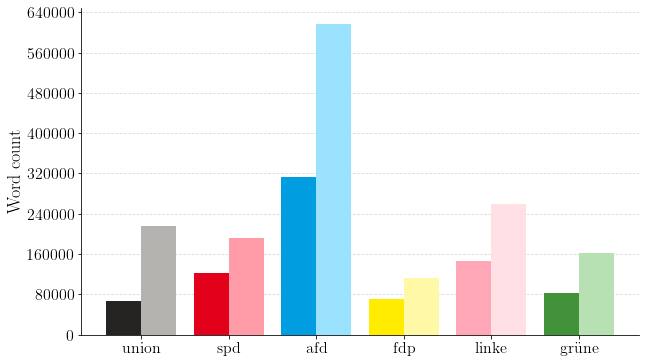

In [31]:
bt_sub_words = {party: len(corpus_bt[party]) for party in parties}
eu_sub_words = {party: len(corpus_eu[party]) for party in parties}

fig = plot_compare_bar(bt_sub_words, eu_sub_words, 'Word count')

fig.savefig('outputs/yt-party-words.pdf', bbox_inches = 'tight', pad_inches = 0)

## Topic analysis algorithms
### tf-idf

In [ ]:
def distinct(df, n=10):
    """ Takes a pandas matrix, where rows are words and columns parties, 
    and returns the n highest distinct words.
    """
    matrix = df.copy()
    parties = matrix.columns
    entries = {party: [] for party in parties}
    while any(map(lambda key: len(entries[key]) < n, entries)):
        next_party = matrix.max().idxmax()
        word = matrix[next_party].idxmax()
        matrix.drop(word, inplace=True)
        entries[next_party].append(word)
        if len(entries[next_party]) >= n:
            matrix.drop(next_party, axis=1, inplace=True)
    return pd.DataFrame(entries)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_bt = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode')
x_bt = v_bt.fit_transform(" ".join(corpus_bt[party]) for party in parties)
df_bt = pd.DataFrame(x_bt.T.toarray(), index=v_bt.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_bt, party, 15) for party in parties))

In [ ]:
distinct(df_bt, 15)

In [ ]:
v_eu = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', norm='l2')
x_eu = v_eu.fit_transform(" ".join(corpus_eu[party]) for party in parties)
df_eu = pd.DataFrame(x_eu.T.toarray(), index=v_eu.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_eu, party, 15) for party in parties))

In [ ]:
distinct(df_eu)

In [ ]:
from wordcloud import WordCloud

fig = generate_wordcloud(df_bt, "TF-IDF - 2016 Bundestag election")
fig.savefig('outputs/yt-tfidf-bt-wordcloud.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = generate_wordcloud(df_eu, "TF-IDF - 2019 European election")
fig.savefig('outputs/yt-tfidf-eu-wordcloud.pdf', bbox_inches = 'tight', pad_inches = 0)

## LDA

In [ ]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.evaluate import results_by_parameter



### Tag based

In [ ]:
data['tags'] = data['tags'].apply(lambda t: t.lower().split("'")[1::2])

climate_tags = ['klima', 'klimaschutz', 'umwelt', 'co2', 'klimaerwärmung', 'klimawandel']
refugee_tags = ['flüchtling', 'einwanderung', 'migrant', 'migranten', 'ausländer', 'zuwanderung', 'flucht']
economy_tags = ['wirtschaft', 'handelsabkommen']

def get_videos_with_certain_tags(tags):
    return data['tags'].apply(lambda vtags: any([t in vtags for t in tags]))

In [ ]:
climate_ids = get_videos_with_certain_tags(climate_tags)
refugee_ids = get_videos_with_certain_tags(refugee_tags)
economy_ids = get_videos_with_certain_tags(economy_tags)
print("Climate: ", len(climate_ids), " Refugee: ", len(refugee_ids), " Economy: ", len(economy_ids))

In [ ]:
tag_corpus = data[climate_ids | refugee_ids | economy_ids]['subtitle'].apply(lambda sub: preprocess(sub))

In [ ]:
v_vids = TfidfVectorizer(sublinear_tf=True, 
                         strip_accents='unicode', 
                         preprocessor=lambda x: x, 
                         tokenizer=lambda x: x)
x_vids = v_vids.fit_transform([sub for sub in tag_corpus])
df_vids = pd.DataFrame(x_vids.T.toarray(), index=v_vids.get_feature_names(), columns=tag_corpus.index)
tags = []
for vid in df_vids.columns:
    tags.append(df_vids.sort_values(vid)[-1:])
tags

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
x = cv.fit_transform(corpus)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
        
lda = LDA(n_components=10, max_iter=20)
lda.fit(x)
print_topics(lda, cv, 20)